# Analyzing and Predicting Consumer Engagement 



![news](https://images.unsplash.com/photo-1584714268709-c3dd9c92b378?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=799&q=80)

Photo by <a href="https://unsplash.com/@thenewmalcolm?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Obi Onyeador</a> on <a href="https://unsplash.com/s/photos/news?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  
  

# Introduction
In this project, we will be using [Internet News and Consumer Engagement dataset](https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement) from Kaggle to predict top article and popularity score. We will be exploring our data to discover patterns, such as correlation, distribution, mean, and time series analysis. We will use both text regression and text classification models to predict engagement score and top article based on the title. 

Text classification is common among the application that we use on daily basis. For example, email providers use text classification to filter out spam emails from your inbox. The other most common use of text classification is in customer care where they use sentimental analysis to differentiate bad reviews from good reviews [ADDI AI 2050](https://medium.com/r/?url=https%3A%2F%2Faddiai.com%2Ftext-classification%2F). We are going to train our model on titles so that it can predict where the article is top or not. Text Regression is similar where we take text vectorized data and predict popularity score which is a decimal value.

> **Our key focus will be on an article title and how it affects other features.** 


## DataSet
[![image.png](Images/1.jpeg)](https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement)

This dataset ([source](https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement)) consists of data about news articles collected from Sept. 3, 2019 until Oct. 4, 2019. Afterwards, it is enriched by Facebook engagement data, such as number of shares, comments and reactions. 

- **Source*id*** column value indicates publisher unique identifier usually presented as lowercase sourcename with spaces replaced with underscore symbol.
- **Source_name** column value indicates publisher name.
- **Author** column value indicates article author. Some publishers do not share information about authors of their news, in this case usually source_name replaces that information.
- **Title** column value indicates headline of an article.
- **Description** column value indicates short article description usually visible in popups or recommendation boxes on the publisher's website. This field is shortened to a few sentences content column.
- **Url** column value indicates URL (Uniform Resource Locator) for article located on the publisher website.
- **Url*to*image** column value indicates a URL to the main image associated with the article.
- **Published_at** column value indicates the exact date and time of publishing the article. Date and time are presented in UTC (+000) time format.
- **Content** column value indicates the unformatted content of the article. This field is truncated to 260 characters.
- **Top_article** column value indicates article listed as a top article on publisher website. This field can have only two values, 1 when the article is contained in the popular/top articles group and 0 otherwise.



## This Notebook is Part of the DataCamp Competition.

[![banner](Images/banner.png)](https://datacamp.com/workspacecompetition)


# Installing required packages
We will be installing **vaderSentiment** for sentiment analysis, **wordcloud** to display most common words used, **lightgbm** for machine learning model, and **imblearn** for unbalanced classification. 

# Loading Required Libraries

In [ ]:
# Statistical packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Text
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS

#ML model
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score
import joblib

#Preprocessing
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

# Over sampling
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import NearMiss


plt.rc('figure',figsize=(8,7.5))

np.random.seed(2021)

# Exploring Data
In this section, we will be exploring our data and visualizing key features to makes sense of consumer engagement.

## Loading Data
After initial review of the data set contains 10437 records and 14 columns. 

**We will be focusing on:**
- Tile of article
- Source name
- Author
- Top Articles
- User Engagement features.


In [ ]:
# Load data from the csv file
df = pd.read_csv('Data/news_articles.csv', index_col=0)
print(f"Number of rows/records: {df.shape[0]}")
print(f"Number of columns/variables: {df.shape[1]}")
df.head()

Number of rows/records: 10437
Number of columns/variables: 14


,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


## Missing Values
Using `.isna().sum()` we can check each column with missing values. To make it fancy we have converted our finding into a table with `NA percent` and color gradient background. As we can observe the majority of *content* and *autor* name columns have missing values.

In [ ]:
NA = pd.DataFrame(data=[df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
            columns=df.columns, index=['NA Count', 'NA Percent']).T.\
            sort_values(by='NA Count',ascending =False)
NA.style.background_gradient(cmap="summer", subset=['NA Count'])

,NA Count,NA Percent
content,1292,12.38%
author,1020,9.77%
url_to_image,656,6.29%
engagement_reaction_count,118,1.13%
engagement_comment_count,118,1.13%
engagement_share_count,118,1.13%
engagement_comment_plugin_count,118,1.13%
description,24,0.23%
title,2,0.02%
top_article,2,0.02%


## Top Ten Author and Source Name
Using seaborn bar plot we have displayed the top 10 authors and source names. We can see that some of the author's names are similar to publication/sources. The top three leader sources are **Reuters**, **BBC News**, and **Irish Times**. The top three authors are **The Associated Press**, **Reuters**, and **CBS News**.

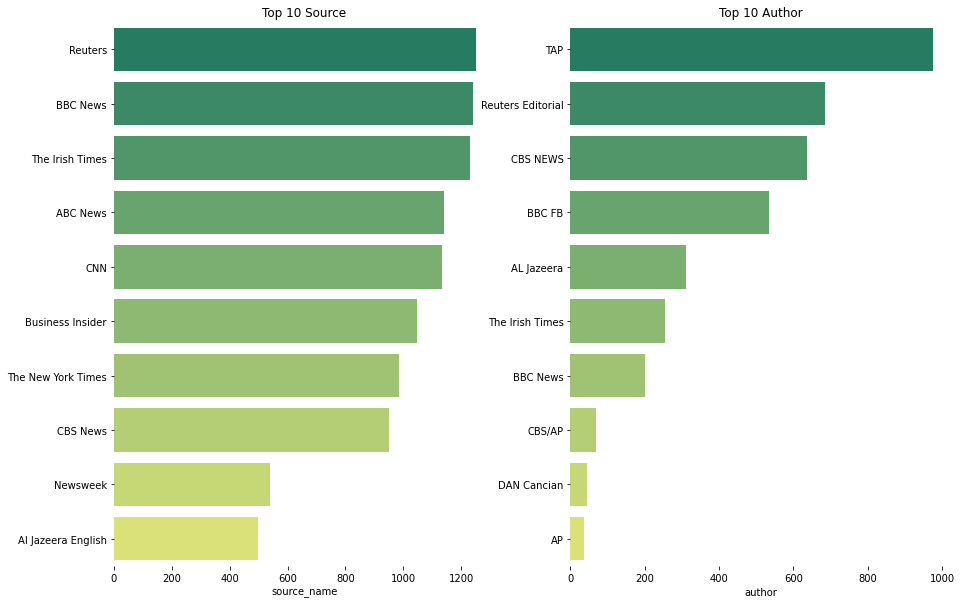

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
source_name = df["source_name"].dropna().value_counts()[:10]
author = df["author"].dropna().value_counts()[:10]

yticklabels = ['TAP',
               'Reuters Editorial',
               'CBS NEWS',
               'BBC FB',
               'AL Jazeera',
               'The Irish Times',
               'BBC News',
               'CBS/AP',
               'DAN Cancian', 
               'AP']
sns.barplot(x=source_name,y=source_name.index,palette='summer',ax=ax1)
sns.barplot(x=author,y=author.index,palette='summer',ax=ax2 )
sns.despine(bottom=True,left=True)
ax1.set(title='Top 10 Source')
ax2.set(title='Top 10 Author')
ax2.set_yticklabels(yticklabels) ;

## Top Article 
Using matplotlib pie chart, we can see the there are on 12 percentage of top articles.

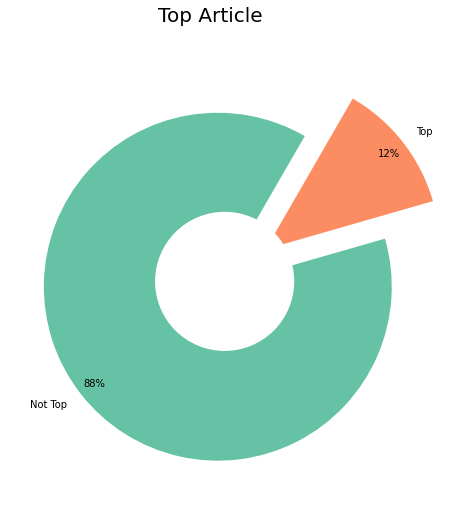

In [ ]:
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Top Article', size = 20, color = "black")
explode = ( 0.05, 0.3)
labels = ["Not Top","Top"]
sizes = df["top_article"].dropna().value_counts()
ax.pie(sizes, 
       explode=explode, 
       colors=sns.color_palette("Set2"),
       startangle=60,
       labels=labels,
       autopct='%1.0f%%',
       pctdistance=0.9)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

## Engagement Boxplots
It was pretty hard to analyze the distribution of engagement data, as they have extreme outliners. We can use `sns.kdeplot` and `np.log1p` to analyze each engagement column, but there is a better way that is to use **boxplot** with *yscale* set to `Symlog`.

- Engagement Reaction count has 1 medium but it has multiple outliners with mean values between 0-60.
- Engagement Comments count has 0 medium but it has multiple outliners with mean values between 0-1.
- Engagement Share count has 10 medium but it has multiple outliners with mean values between 0-50.
- Engagement Comments Plugin count has 0 medium but it has multiple outliners with a mean value is 0.

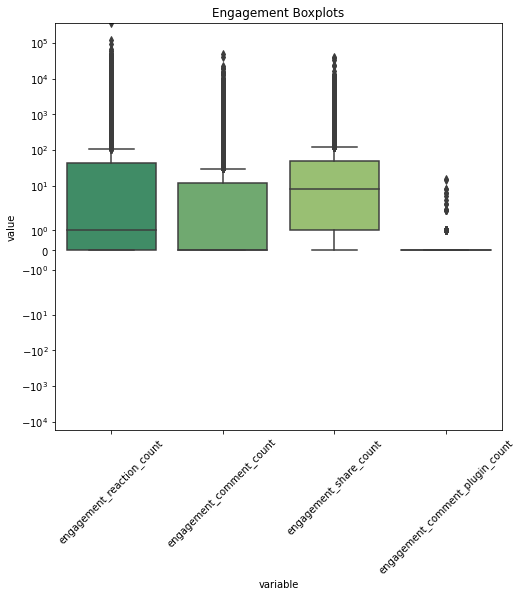

In [ ]:
eng = ['engagement_reaction_count',
       'engagement_comment_count',
       'engagement_share_count',
       'engagement_comment_plugin_count'] 
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df[eng]),palette='summer')
ax.set_title('Engagement Boxplots')
plt.xticks(rotation=45)
ax.set_yscale('Symlog')
plt.show()

### Comment Plugin
Let's check out the comment plugin in as it has the oddest data with 0 mean and 0 median. As we can see 99 percent of data is ZERO and the rest of them are outliners from 1-15.

In [ ]:
pd.DataFrame(df["engagement_comment_plugin_count"].\
             value_counts().\
             reset_index().\
             rename(columns = {'index':'engagement_comment_plugin',
                               'engagement_comment_plugin_count':'Counts'})).\
            astype(int).\
            style.background_gradient(cmap="summer", subset=['Counts'])

,engagement_comment_plugin,Counts
0,0,10269
1,1,32
2,2,8
3,6,2
4,8,2
5,3,2
6,15,1
7,5,1
8,4,1
9,14,1


## Clean title
Let's clean our title as we will be using it in our machine learning model.

There are punctuation marks and capitalized words within our text data that will make our model perform worst.

In [ ]:
df['title'][0:5]

0    NTSB says Autopilot engaged in 2018 California...
1         Unemployment falls to post-crash low of 5.2%
2    Louise Kennedy AW2019: Long coats, sparkling t...
3    North Korean footballer Han joins Italian gian...
4    UK government lawyer says proroguing parliamen...
Name: title, dtype: object

`clean_title` function will clean for brackets, hyperlinks, punctuation, and words containing numbers.

In [ ]:
def clean_title(x:str):    
    # lowering the text
    x=x.lower() 
 
    #removing square brackets
    x = re.sub('\[.*?\]', '', x)
    x = re.sub('<.*?>+', '', x) 

    #removing hyperlink
    x = re.sub('https?://\S+|www\.\S+', '', x) 

    #removing puncuation
    x = re.sub('[%s]' % re.escape(string.punctuation), '', x) 
    x = re.sub('\n', '', x) 

    #remove words containing numbers
    x = re.sub('\w*\d\w*', '', x) 
    return x

Adding new columns containing clean titles

In [ ]:
df['clean_title'] = df['title'].astype(str).apply(clean_title) 
df['clean_title'][0:5]

0    ntsb says autopilot engaged in  california tes...
1              unemployment falls to postcrash low of 
2    louise kennedy  long coats sparkling tweed dre...
3    north korean footballer han joins italian gian...
4    uk government lawyer says proroguing parliamen...
Name: clean_title, dtype: object

## Creating sentimental polarity 
Using Vader Sentiment Intensity Analyzer we are going to extract scores from the clean title and dividing them into 3 categories **Positive**, **Negative**, and **Neutral**.

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

## Sentiments
def sentiment(score):
    emotion = ""
    if score >= 0.5:
        emotion = "Positive"
    elif score <= -0.5:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

### Applying Compund score

In [ ]:
polarity_scores = df["clean_title"].astype("str").apply(compound_score)
df["Sentiment_Score"] = polarity_scores

### Applying Sentiment

In [ ]:
df["Sentiment"] = df["Sentiment_Score"].apply(sentiment)

As we can see we have added 2 columns in our dataset with sentiment score and emotions based on score.

In [ ]:
df.head()

### Countplot on sentiment categories
The News title has mostly neutral sentiments and negative emotions to see the news.

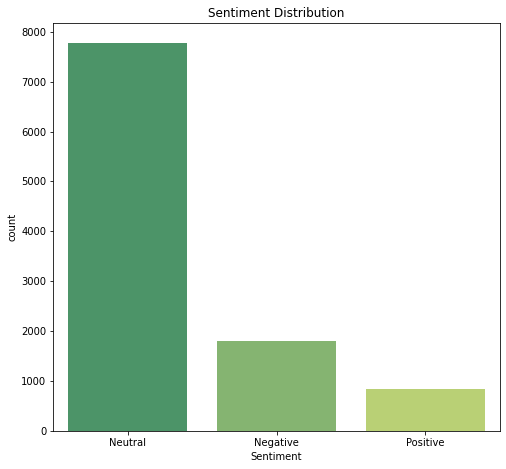

In [ ]:
sns.countplot(data=df,x="Sentiment",palette="summer")
plt.title('Sentiment Distribution');

## Word Cloud
We will use the word cloud library to display the most common word used in both Title and Description.

In [ ]:
np.array(list(STOPWORDS))[0:5]

array(['before', "shan't", 'in', 'has', "we're"], dtype='<U10')

Most common words are **say, new, said, will and Trump**. We have used english stopwords to remove common words present in every sentence.

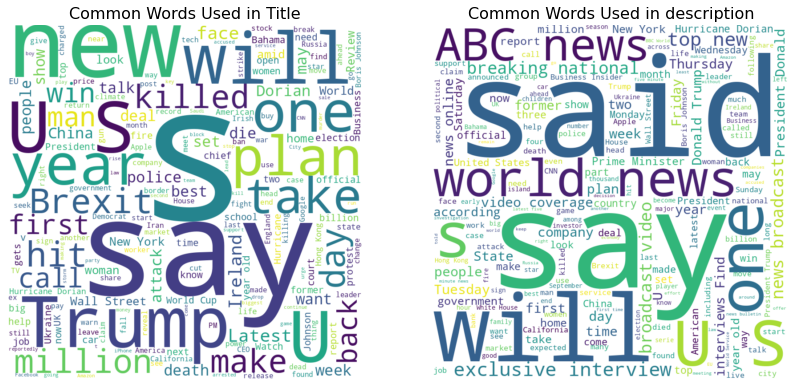

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 14], facecolor = None)


wc = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True,stopwords = STOPWORDS)
wc.generate("".join(df['title'].astype(str)))
ax1.axis("off")
ax1.imshow(wc, interpolation="bilinear")
ax1.set_title('Common Words Used in Title',fontsize=16);


wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True,stopwords = STOPWORDS)
wc2.generate("".join(df['description'].astype(str)))
ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Common Words Used in description',fontsize=16);

## Time series
We will be plotting consumer engagements on date from Sept. 3, 2019, until Oct. 3, 2019.


### Spliting Date Time
We will be spliting date into day of week, month, and year, then adding them into dataframe.

In [ ]:
df['published_at'] = pd.to_datetime(df['published_at'])

df['Day_Of_Week'] = df['published_at'].apply(lambda x: x.dayofweek)
df['Month'] = df['published_at'].apply(lambda x: x.month)
df['Year'] = df['published_at'].apply(lambda x: x.year)

### Number of Engagement over month
Using seaborn line plot to display consumer engagement pattern over the month. There is a spike in consumer engagement on 1st October. Maybe it's due to a major event. Other than that there are smaller peaks in reaction engagements on 3rd, 7th, and 12th September.

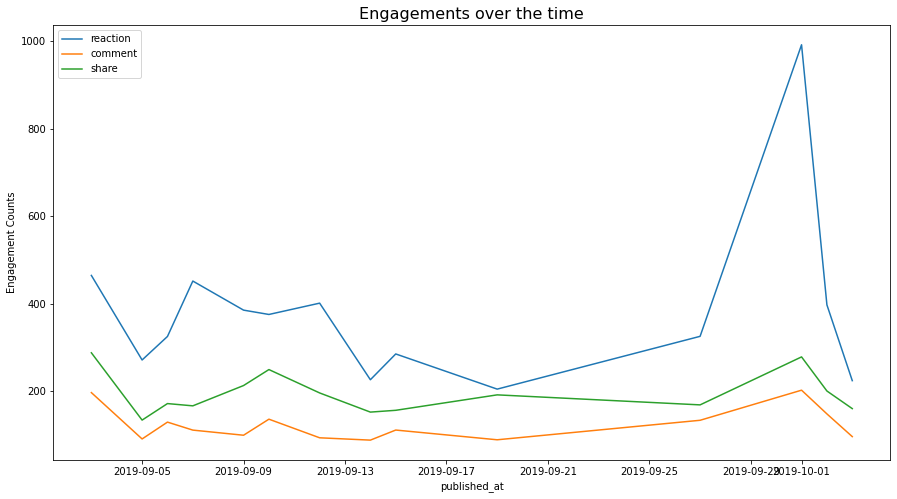

In [ ]:
fig, ax1 = plt.subplots( figsize=[15, 8], facecolor = None)

date_mean = df.copy()
date_mean['published_at'] = pd.to_datetime(date_mean['published_at']).dt.normalize()
date_mean = date_mean.groupby(by='published_at').mean().reset_index()

ax1 = sns.lineplot(
    data=date_mean, x="published_at", y="engagement_reaction_count",label = 'reaction'
)

ax1 = sns.lineplot(
    data=date_mean, x="published_at", y="engagement_comment_count",label = 'comment'
)

ax1 = sns.lineplot(
    data=date_mean, x="published_at", y="engagement_share_count", label = 'share'
)
plt.ylabel('Engagement Counts')
plt.title('Engagements over the time',fontsize=16);

## Coorelation Heatmap
There is a high positive correlation between reaction, comment, and share engagement. The consumer who likes the post is most likely to share and comment. There is no other significant correlation between engagements and top articles, this is evident that selection of top article is purely based on quality. 

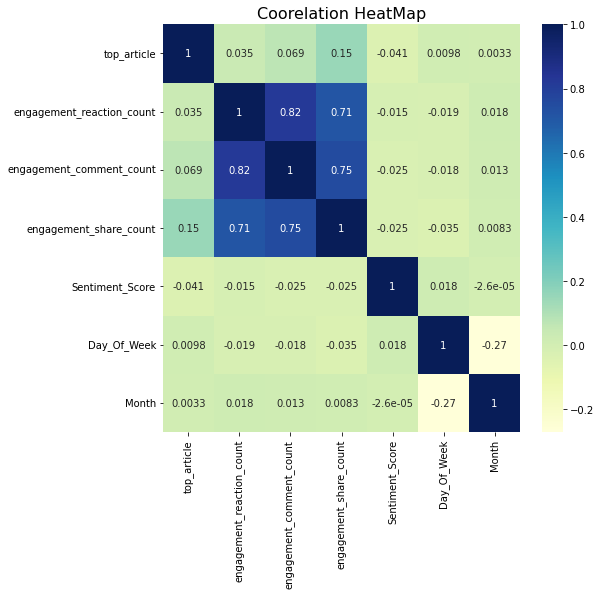

In [ ]:
dataplot = sns.heatmap(df.drop(columns = ['Year','engagement_comment_plugin_count']).corr(),
                       cmap="YlGnBu", annot=True)
dataplot.set_title('Coorelation HeatMap',fontsize=16)  
# displaying heatmap
plt.show()

# Preprocessing
- Replace missing titles
- Convert titles into vectors
- Replace missing values in top_article
- Over sampling using SMOTE
- Creating popularity pcore

## Tfidf Vectorizer
Our machine learning models understand only numerical values so in order to train our model on text data we will convert it to a matrix of TF-IDF features. [SKlearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidfvectorizer#sklearn.feature_extraction.text.TfidfVectorizer)

In [ ]:
df['clean_title'].fillna('Missing',inplace=True)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2),
                            dtype=np.float32, 
                            sublinear_tf=True, 
                            use_idf=True, 
                            smooth_idf=True)
train_tfidf = tfidf_vec.fit_transform(df['clean_title'])



## Oversampling
Our `top_article` data is unbalanced as we only have 12 percent of 1's. In order to make our model perform better, we will be using oversampling method SMOTE (Synthetic Minority Over-sampling Technique). I have also tried other oversampling and under sampling methods but SMOTE performed better.  

In [ ]:
list_labels = df["top_article"].fillna(0)

In [ ]:
list_labels.value_counts()

0.0    9163
1.0    1274
Name: top_article, dtype: int64

In [ ]:
OS = SMOTE()
X,Y = OS.fit_resample(train_tfidf,list_labels)

## Popularity Score
We will be adding all fours engagement columns and then taking `np.log1p(X)` which is similar to `np.log(X+1)`. Many zero engagements will result in infinity so adding 1 to all columns will avoid disaster. 

In [ ]:
df['Popularity_Score'] = np.log1p((df['engagement_reaction_count'] + \
                         df['engagement_comment_count']+\
                         df['engagement_share_count']+\
                         df['engagement_comment_plugin_count']))

We can clearly see the majority of distribution is between 0-3.

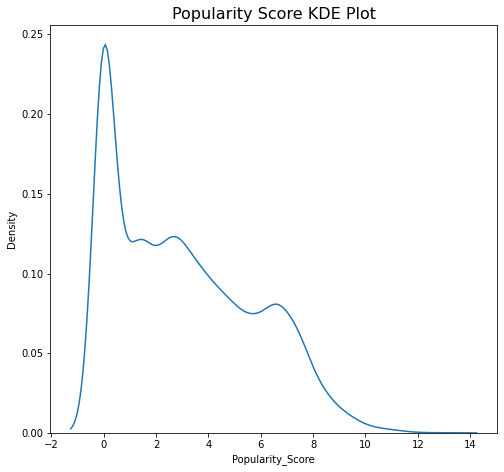

In [ ]:
sns.kdeplot(df['Popularity_Score'])
plt.title('Popularity Score KDE Plot',fontsize=16);

We can clearly see the top 2 popular publishing companies are **The New York Times** and **CNN**.  

In [ ]:
df.groupby(by='source_name').\
    mean()['Popularity_Score'].\
    to_frame().\
    sort_values(by='Popularity_Score',
                ascending=False)

,Popularity_Score
source_name,
The New York Times,4.777518
CNN,4.418373
Business Insider,3.855361
Al Jazeera English,3.720652
The Wall Street Journal,3.499767
CBS News,3.163584
BBC News,2.929104
Newsweek,2.674136
Reuters,2.673019


# Test Classifier Model
Let's build a model that will take titles and predict whether the article will be become top or not. 
- X : title
- y : top_article 

## Build Model

We have experimented with SGD and Random Forest classifier but by far light gradient boosting model performed better. After hyperparameter tunning our model was is ready to be trained on the dataset.

- Splitting into train and test.
- Stratify our top_article so they are equaly distributed.
- Using LGBMClassifier
    - learning_rate=0.5,
    - max_depth=20,
    - num_leaves=50, 
    - n_estimators=120,
    - max_bin=2000
- Cross Validation
- Training and Testing
- Confusion Matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.1,
                                                    stratify = Y ,
                                                    random_state=40)

modeltop = LGBMClassifier(verbose=-1,
                          learning_rate=0.5,
                          max_depth=20,
                          num_leaves=50, 
                          n_estimators=120,
                          max_bin=2000,)

## Cross Validation

After cross-validation of our model, we can observe that our f1 score is quite stable. 0.9 is the best we could achieve. 

In [ ]:
scores = cross_val_score(
                 modeltop, X_train, y_train, cv=5, scoring='f1_macro')

print("Cross Validation F1 Scores : ",scores)

Cross Validation F1 Scores :  [0.90601464 0.90508244 0.90231021 0.89712144 0.90382022]


## Train/Test Model
After fitting our model on the training dataset we can see both `f1` and `accuracy_scores` are +0.9 on our test dataset.

In [ ]:
modeltop.fit(X_train,y_train)

predtop = modeltop.predict(X_test)
print("f1 score : ",round(f1_score(predtop,y_test),2))
print("accuracy score : ",round(accuracy_score(predtop,y_test),2))

f1 score :  0.9
accuracy score :  0.9


### save model

In [ ]:
joblib.dump(modeltop, 'Models/lgb_top.pkl')

['Models/lgb_top.pkl']

## Confusion Matrix
We have a few false positives and false negatives. In general, our LGBM model performed better the expected. 

In [ ]:
y_test.value_counts()

0.0    917
1.0    916
Name: top_article, dtype: int64

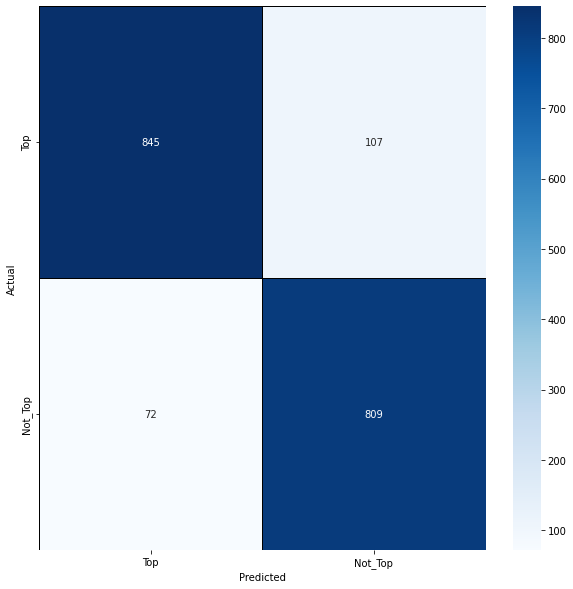

In [ ]:
plt.figure(figsize = (10,10))
cm = confusion_matrix(predtop, y_test)
sns.heatmap(cm,cmap= "Blues",
            linecolor = 'black' ,
            linewidth = 1 ,
            annot = True,
            fmt='' ,
            xticklabels = ['Top','Not_Top'] ,
            yticklabels = ['Top','Not_Top'])
plt.xlabel("Predicted")
plt.ylabel("Actual");

# Text Regression Model

- X : title
- y : Popularity_score

We are going to use the vectorized title to predict the popularity score. I have experimented with logistic regression and random forest regressor, but Light Gradient Boosting performed well in our case.

- Filling missing values with 1.
- Train and Test split
- LGBMRegressor
    -  learning_rate=0.01,
    -  max_depth=20,
    -  num_leaves=50,
    -  n_estimators=150
- Cross Validation
- Training and Testing

## Train Test Split

In [ ]:
list_labels = df["Popularity_Score"].fillna(1)

X_train, X_test, y_train, y_test = train_test_split(train_tfidf,
                                                    list_labels,
                                                    test_size=0.2,
                                                    random_state=40)

## Build Model

In [ ]:
model1 = LGBMRegressor(verbose=-1,
                       learning_rate=0.01,
                       max_depth=20,
                       num_leaves=50,
                       n_estimators=150)

## Validation Score
The model performed well as without hyperparameter tuning and logistic regression the score was 8+ RMSE.

In [ ]:
scores = cross_val_score(
                 model1, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print("Cross Validation RMSE Scores : ",-scores)

Cross Validation RMSE Scores :  [2.55957823 2.61835608 2.61620127 2.53990543 2.57260691]


## Training and Testing
After fitting the model on the training dataset it seems like our model preform quite well on the test dataset too. Now we will be using both models to build a function for title scoring.

In [ ]:
model1.fit(X_train,y_train)

pred1 = model1.predict(X_test)
print("RMSE: ",round(np.sqrt(mean_squared_error(pred1,y_test)),2))

RMSE:  2.57


### Save model

In [ ]:
joblib.dump(model1, 'Models/lgb_pop.pkl')

['Models/lgb_pop.pkl']

# Title Scoring
`title_score` function takes the title and output the popularity score and classify top Article. Total Engamenet which includes reaction, share, and comments. We can use these functions to create the best possible titles for our blogs.

Funtion Tasks:
- Clean the text
- Vectorized the text
- Predict top article and popularity score
- Print top article, the popularity score, and total engagement.

In [ ]:
def title_score(title):
    text = clean_title(title)
    text = tfidf_vec.transform([text])
    top_cat = modeltop.predict(text)
    pop = model1.predict(text)
    print("Top Article :" , top_cat[0].astype(bool))
    print("Popularity Score :" , round(pop[0],2))
    print("Total Engagement :" , int(np.expm1(pop[0])))
    return top_cat,pop
    

## Testing
It's time to test both our function and our predictive models. We will be first testing the random value within our data set and then using titles from today's news to determine the score. 

In [ ]:
df[df['top_article']==1]['title'].values[10]

"Here's what Hurricane Dorian is expected to do as it crawls toward the US"

As we can clearly see our function and both models work.

In [ ]:
title_score("Here's what Hurricane Dorian is expected to do as it crawls toward the US");

Top Article : True
Popularity Score : 3.18
Total Engagement : 23


## Latest News

### Testing on randome latest News 

In [ ]:
title_score("Here Are the States With the Lowest COVID-19 Vaccination Rates");

Top Article : False
Popularity Score : 2.73
Total Engagement : 14


### Testing on Top News
As we can see it got high popularity score.

In [ ]:
title_score("Farmworker Found Guilty of Murdering Iowa Student Is Sentenced to Life in Prison");

Top Article : False
Popularity Score : 4.14
Total Engagement : 61


We have tested again on top article from news and as we can see it is top article according to our model.

In [ ]:
title_score("Plea Deal Offered to U.S. Capitol Rioter Accused of Grabbing Officer's Gas Mask");

Top Article : True
Popularity Score : 2.16
Total Engagement : 7


# Conclusion
We had fun exploring the data and playing around with different machine learning techniques and models. In short, we have explored our data and presented unique information that can help the News agency create better content that gets high traction from the consumers. We have developed machine learning models that will help writers and bloggers to write better titles. We have also discovered that high popularity doesn't mean that it's going to be a top article. 

For future work, I would like to explore multiple clusters within the data and create a model using images of the article to predict popularity scores. I have experimented with deep learning text generation models but due to memory constraints, I was limited to simple tabular models. 

**To learn more about Data Analysis, Natural Lanugae Processing, and Machine Learning in general I will suggest you take an amazing Data camp course and practice the exercise on your own.**

> ![image.png](Images/2.jpeg)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6da86419-8c62-4e7d-95b4-de4973e49e4c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>